<center> <b> <h1> logistic regression </h1></b></center>


In [2]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import joblib

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report

import pandas as pd
import numpy as np
import itertools

from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

PATH_DATASETS = "../../2_Data_preparation/2_Split_Raw_Datasets/output/"
PATH_OUTPUT = "output/"

In [3]:
def readCsvs(split):
    datasets = []
    constant1 = 'X_'
    constant2 = '_' + split
    features = ['area', 'meancurv', 'thickness', 'volume']

    for feature in features:
        df = pd.read_csv(PATH_DATASETS + constant1 + feature + constant2 +'.csv', index_col=0)
        datasets.append({'name': feature, 'data': df})
    return datasets

# 1. Data preparing

In [4]:
df_X_tr = readCsvs('train')
df_X_tr[2]['data'].shape

(550, 148)

In [5]:
df_y_train = pd.read_csv(PATH_DATASETS + 'Y_train.csv', index_col = 0)
df_y_train.shape

(550, 1)

In [6]:
df_X_val = readCsvs('validate')
df_X_val[0]['data'].shape

(338, 148)

In [7]:
df_y_val = pd.read_csv(PATH_DATASETS + 'Y_validate.csv', index_col = 0)
df_y_val.shape

(338, 1)

In [8]:
df_X_tr[0]['data'].head()

,lh_G_and_S_frontomargin_area,lh_G_and_S_occipital_inf_area,lh_G_and_S_paracentral_area,lh_G_and_S_subcentral_area,lh_G_and_S_transv_frontopol_area,lh_G_and_S_cingul-Ant_area,lh_G_and_S_cingul-Mid-Ant_area,lh_G_and_S_cingul-Mid-Post_area,lh_G_cingul-Post-dorsal_area,lh_G_cingul-Post-ventral_area,...,rh_S_parieto_occipital_area,rh_S_pericallosal_area,rh_S_postcentral_area,rh_S_precentral-inf-part_area,rh_S_precentral-sup-part_area,rh_S_suborbital_area,rh_S_subparietal_area,rh_S_temporal_inf_area,rh_S_temporal_sup_area,rh_S_temporal_transverse_area
414229,887,1169,1037,1196,490,1763,1134,1041,360,153,...,1603,1201,1700,1460,1009,203,532,793,3688,184
541943,838,1195,853,1061,427,1425,830,926,316,162,...,1580,2187,1431,1024,710,366,847,1292,3675,177
206525,1079,1373,918,1214,508,2163,1053,978,363,474,...,2130,1577,2101,1014,1269,344,1232,1252,5678,239
146533,1058,1312,1105,941,524,2234,1138,1008,369,265,...,1899,1098,2033,1118,1421,232,768,765,4957,164
194746,731,1179,800,985,437,1477,896,960,369,192,...,1547,1220,1691,946,916,156,745,967,4002,206


# 2. Normalize data

In [9]:
for df_tr, df_val in zip(df_X_tr, df_X_val):
    train = df_tr['data']
    val = df_val['data']
    
    normal_tr = (train - train.mean(axis=0))/train.std()
    normal_val = (val - val.mean(axis=0))/val.std()
    
    df_tr['data'] = normal_tr
    df_val['data'] = normal_val

In [10]:
df_X_tr[0]['data'].head()

,lh_G_and_S_frontomargin_area,lh_G_and_S_occipital_inf_area,lh_G_and_S_paracentral_area,lh_G_and_S_subcentral_area,lh_G_and_S_transv_frontopol_area,lh_G_and_S_cingul-Ant_area,lh_G_and_S_cingul-Mid-Ant_area,lh_G_and_S_cingul-Mid-Post_area,lh_G_cingul-Post-dorsal_area,lh_G_cingul-Post-ventral_area,...,rh_S_parieto_occipital_area,rh_S_pericallosal_area,rh_S_postcentral_area,rh_S_precentral-inf-part_area,rh_S_precentral-sup-part_area,rh_S_suborbital_area,rh_S_subparietal_area,rh_S_temporal_inf_area,rh_S_temporal_sup_area,rh_S_temporal_transverse_area
414229,0.309576,0.224009,1.107822,1.264846,-0.053643,0.447702,0.977805,0.781809,-0.594180,-0.761092,...,0.221416,0.381852,-0.114597,1.444931,0.064915,-0.435619,-1.510187,-0.718114,-1.077114,-0.575371
541943,-0.076249,0.352958,-0.262869,0.412671,-0.728809,-0.994397,-0.892543,-0.132296,-1.093925,-0.695517,...,0.137165,3.971853,-0.980071,-0.602848,-1.391463,1.763449,-0.070073,1.569996,-1.101390,-0.732631
206525,1.821379,1.235757,0.221342,1.378470,0.139262,2.154329,0.479456,0.281038,-0.560107,1.577744,...,2.151850,1.750859,1.175570,-0.649815,1.331331,1.466642,1.690066,1.386581,2.638980,0.660251
146533,1.656025,0.933225,1.614382,-0.344818,0.310732,2.457255,1.002415,0.519500,-0.491960,0.054950,...,1.305682,0.006832,0.956788,-0.161354,2.071697,-0.044374,-0.431244,-0.846505,1.292596,-1.024687
194746,-0.918764,0.273605,-0.657688,-0.067072,-0.621640,-0.772536,-0.486481,0.137961,-0.491960,-0.476934,...,0.016284,0.451031,-0.143553,-0.969194,-0.388072,-1.069706,-0.536396,0.079744,-0.490755,-0.081122


In [11]:
df_X_val[0]['data'].head()

,lh_G_and_S_frontomargin_area,lh_G_and_S_occipital_inf_area,lh_G_and_S_paracentral_area,lh_G_and_S_subcentral_area,lh_G_and_S_transv_frontopol_area,lh_G_and_S_cingul-Ant_area,lh_G_and_S_cingul-Mid-Ant_area,lh_G_and_S_cingul-Mid-Post_area,lh_G_cingul-Post-dorsal_area,lh_G_cingul-Post-ventral_area,...,rh_S_parieto_occipital_area,rh_S_pericallosal_area,rh_S_postcentral_area,rh_S_precentral-inf-part_area,rh_S_precentral-sup-part_area,rh_S_suborbital_area,rh_S_subparietal_area,rh_S_temporal_inf_area,rh_S_temporal_sup_area,rh_S_temporal_transverse_area
615441,0.238801,1.162366,-1.326521,1.519078,0.392378,0.149223,-0.548379,-0.452876,-0.095789,2.679350,...,1.287450,0.292080,1.757860,-0.218747,-0.883145,-0.107213,0.140636,-0.557016,-0.424721,1.220303
616645,-0.138682,-0.365142,0.053695,0.208336,0.641297,0.515571,0.884371,0.914182,1.960390,1.791415,...,0.846211,0.428161,1.281187,0.122919,1.162747,2.987705,-0.998039,1.386738,1.932750,0.497058
618952,1.437867,-0.245805,0.877704,1.245774,1.298443,1.298549,2.002875,0.990983,1.310509,1.578680,...,2.255210,0.236047,1.281187,0.025300,0.726963,1.055014,0.714798,2.354218,0.787643,0.518330
650746,-0.279313,1.171913,0.493166,1.731027,0.661211,0.142040,2.626042,0.706819,-0.170366,0.071039,...,0.760930,0.065278,0.504144,1.021010,-1.254708,0.258431,-0.751969,-0.183217,0.470325,1.220303
662551,1.852359,-1.052520,-0.131707,0.643391,-0.264767,0.425780,-0.186197,0.491776,1.512931,0.607500,...,0.041599,-0.471043,0.948169,0.757440,-0.144605,0.167020,-1.538426,0.669924,1.275693,0.454514


# Logistic Regression without hyper parameter tunning all ROIS

In [12]:
for feature, feature_val in zip(df_X_tr, df_X_val):
    name = feature['name']
    data = feature['data']
    data_val = feature_val['data']
    
    print(name)
    
    linear_model = LogisticRegression(penalty = 'l1', C = 5, n_jobs = -1, max_iter = 1000, solver = 'saga')
    linear_model.fit(data, df_y_train['class'])
    print("train score: ")
    print(linear_model.score(data, df_y_train['class']))
    
    #making prediction 
    score_val = linear_model.score(data_val, df_y_val['class'])
    
    print("validation score: ")
    print(score_val)
    #print(linear_model.coef_[0])

area
train score: 
0.8054545454545454
validation score: 
0.6804733727810651
meancurv
train score: 
0.8127272727272727
validation score: 
0.6568047337278107
thickness
train score: 
0.8163636363636364
validation score: 
0.6863905325443787
volume
train score: 
0.8363636363636363
validation score: 
0.6923076923076923


# Hyper parameter tunning 

In [13]:
def GridSearch(df_X_tr, df_X_val):
    param_grid = {'C': np.arange(0.001, 1, 0.001),
                  'warm_start': [True, False]}
    scores = ['precision', 'recall']
    best_configuration = []

    for feature_train, feature_validate in zip(df_X_tr, df_X_val):

        data_name = feature_train['name']
        data_train = feature_train['data']
        data_validate = feature_validate['data']

        print("******************************** GRID SEARCH FOR: " + data_name + " ******************************")

        for score in scores:
            print("# Tuning hyper-parameters for %s" % score)
            print()

            linear_model = LogisticRegression(penalty = 'l1', n_jobs = -1, max_iter = 10000, solver = 'saga')
            clf = GridSearchCV(linear_model, param_grid, verbose=0, n_jobs=-1, scoring='%s_macro' % score, cv = 5)
            clf.fit(data_train, df_y_train['class'].values)

            if (score == 'precision'):
                best_configuration.append({'name' : data_name, 'data' : clf.best_params_})

            print("Best parameters set found on development set: ", clf.best_params_)
            print("Grid scores on develpment set: ")
            means = clf.cv_results_['mean_test_score']
            stds = clf.cv_results_['std_test_score']

            print("Detailed Classification Report: ")
            print("the model is trained on the full development set.")
            print("The scores are computed on the full evaluation set.")
            y_true, y_pred = df_y_val, clf.predict(data_validate)
            print(classification_report(y_true,y_pred))
            print()
            
    return best_configuration

In [14]:
best_configuration = GridSearch(df_X_tr, df_X_val)

******************************** GRID SEARCH FOR: area ******************************
# Tuning hyper-parameters for precision

Best parameters set found on development set:  {'C': 0.036000000000000004, 'warm_start': True}
Grid scores on develpment set: 
Detailed Classification Report: 
the model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

          -1       0.73      0.72      0.73       173
           1       0.71      0.72      0.72       165

    accuracy                           0.72       338
   macro avg       0.72      0.72      0.72       338
weighted avg       0.72      0.72      0.72       338


# Tuning hyper-parameters for recall

Best parameters set found on development set:  {'C': 0.035, 'warm_start': False}
Grid scores on develpment set: 
Detailed Classification Report: 
the model is trained on the full development set.
The scores are computed on the full evaluation se

In [15]:
best_configuration

[{'name': 'area', 'data': {'C': 0.036000000000000004, 'warm_start': True}},
 {'name': 'meancurv', 'data': {'C': 0.157, 'warm_start': True}},
 {'name': 'thickness', 'data': {'C': 0.15, 'warm_start': True}},
 {'name': 'volume', 'data': {'C': 0.124, 'warm_start': True}}]

In [16]:
clfs = []
for feature, feature_tr in zip (best_configuration, df_X_tr):
    C = feature['data']['C']
    warm_start = feature['data']['warm_start']
    
    data_name = feature_tr['name']
    df_train = feature_tr['data']
    
    # create and train
    linear_model = LogisticRegression(penalty = 'l1',
                                       n_jobs = -1,
                                       max_iter = 10000,
                                       solver = 'saga',
                                       C = C, 
                                       warm_start = warm_start)
    
    linear_model.fit(df_train, df_y_train['class'].values)
    
    #checking the score 
    print("Score for train " + data_name + ": ", linear_model.score(df_train,df_y_train['class'].values))
    
    #saving the classificator
    joblib.dump(linear_model, 'output/logistic_regression (optimal)' + data_name +'.pkl')
    
    #saving an instance  of the clf 
    clfs.append({'name' : data_name, 'data' : linear_model})

Score for train area:  0.7145454545454546
Score for train meancurv:  0.7836363636363637
Score for train thickness:  0.7618181818181818
Score for train volume:  0.7763636363636364


# Confusion Matrix

In [17]:
def plot_confusion_matrix(cm, classes, normalize = False,
                         title = 'Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalie = True'
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[: np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    # '.2f' limits float to two decimal point
    # 'd' number decimal
    fmt = '.2f' if normalize else 'd' 
    
    thresh = cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format (cm[i,j], fmt), horizontalalignment = "center", verticalalignment = "center",
                 color = "white" if cm[i,j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('true label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[125  48]
 [ 46 119]]
Normalized confusion matrix
[[0.72 0.29]
 [0.27 0.72]]


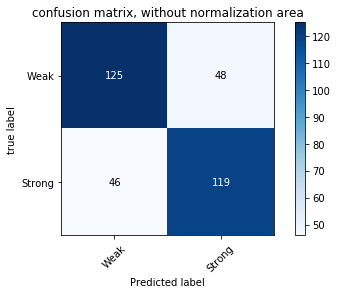

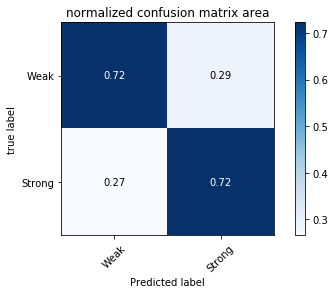

Confusion matrix, without normalization
[[118  55]
 [ 49 116]]
Normalized confusion matrix
[[0.68 0.33]
 [0.28 0.7 ]]


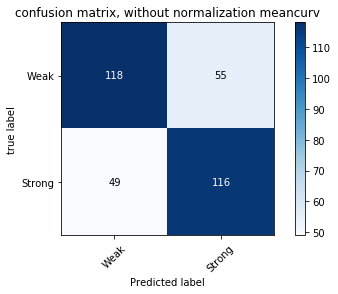

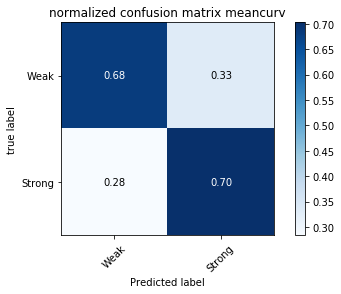

Confusion matrix, without normalization
[[127  46]
 [ 43 122]]
Normalized confusion matrix
[[0.73 0.28]
 [0.25 0.74]]


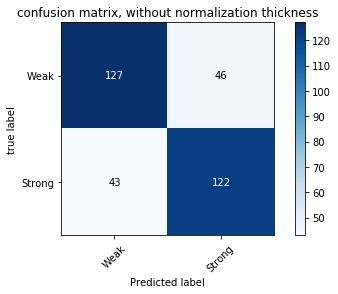

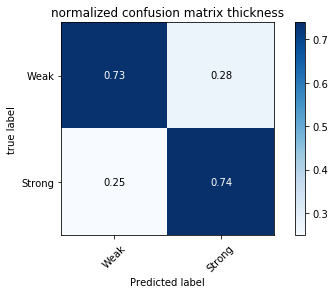

Confusion matrix, without normalization
[[125  48]
 [ 42 123]]
Normalized confusion matrix
[[0.72 0.29]
 [0.24 0.75]]


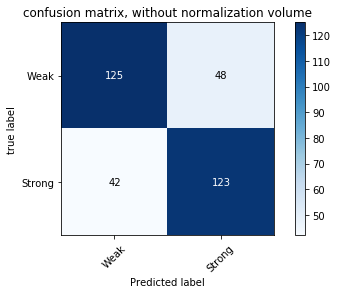

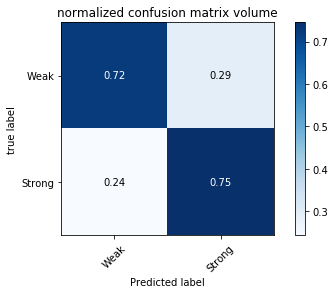

In [18]:
for feature, clf in zip(df_X_val, clfs):
    data = feature['data']
    name = feature['name']
    clf_data = clf['data']
    
    # Compute Confusion matrix
    cnf_matrix = confusion_matrix(df_y_val['class'].values, clf_data.predict(data))
    np.set_printoptions(precision=2)

    # Plot non-normalied confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['Weak', 'Strong'],
                         title='confusion matrix, without normalization '+ name)

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['Weak', 'Strong'], normalize=True,
                         title='normalized confusion matrix '+ name)
    plt.show()


# 3. Ranking

### create df

In [19]:
best_regions_dfs = []
for df_feature in df_X_tr:
    #get name and data
    name = df_feature['name']
    data = df_feature['data']
    
    df_results = pd.DataFrame(columns=['Name', 'coef'])
    df_results['Name'] = data.columns.values
    df_results['coef'] = 0.0
    df_results.set_index('Name', inplace = True)
    
    best_regions_dfs.append({'name' : name, 'data' : df_results})

In [20]:
best_regions_dfs[0]['data']. head()

,coef
Name,
lh_G_and_S_frontomargin_area,0.0
lh_G_and_S_occipital_inf_area,0.0
lh_G_and_S_paracentral_area,0.0
lh_G_and_S_subcentral_area,0.0
lh_G_and_S_transv_frontopol_area,0.0


In [21]:
for clf, best_regions_df_t in zip(clfs, best_regions_dfs):
    clf_data = clf['data']
    name = clf['name']
    
    best_regions_df = best_regions_df_t['data']  
    coefs = clf_data.coef_
    
    for roi in zip(best_regions_df.index.values, coefs[0]):
        if roi[1] != 0: 
            #print(roi[1])
            best_regions_df.at[roi[0],"coef"] = round(abs(roi[1]),2)

In [22]:
best_regions_dfs[0]['data'].sort_values('coef', ascending = False, inplace = True)
best_regions_dfs[0]['data']

,coef
Name,
lh_S_orbital_med-olfact_area,0.17
lh_G_and_S_frontomargin_area,0.11
lh_G_cuneus_area,0.11
rh_Pole_occipital_area,0.10
lh_Pole_occipital_area,0.09
...,...
lh_S_circular_insula_ant_area,0.00
lh_S_cingul-Marginalis_area,0.00
lh_S_central_area,0.00


In [23]:
for best_regions_df in best_regions_dfs:
    
    data = best_regions_df['data']
    name = best_regions_df['name']
    
    data.sort_values('coef', inplace = True, ascending = False)
    data.to_csv("output/ranking_logistic_regression_" + name + ".csv")
    data[data["coef"]>0.0].to_csv("output/used_regions_logistic_regression_" + name + ".csv")

In [24]:
for best_regions_df in best_regions_dfs:
    
    data = best_regions_df['data']
    name = best_regions_df['name']
    
    data.sort_values('coef', inplace = True, ascending = False)
    print(name)
    print(data[data["coef"]>0.0].shape)

area
(20, 1)
meancurv
(72, 1)
thickness
(52, 1)
volume
(53, 1)


In [23]:
 for feature, clf in zip(df_X_val, clfs):
    data = feature['data']
    name = feature['name']
    clf_data = clf['data']
    
    y_pred = clf_data.predict(data)
    score = accuracy_score(y_pred, df_y_val['class'])
    
    print(name)
    print(score)


area
0.7218934911242604
meancurv
0.6923076923076923
thickness
0.7366863905325444
volume
0.7337278106508875
